In [79]:
#!pip install missingno

In [80]:
import pandas as pd
from pandas.api.types import CategoricalDtype
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn as skl
import missingno as msno
from scipy.stats import chi2_contingency
from tqdm import tqdm
import scipy.stats as st
import matplotlib.cm as cm
import matplotlib.colors as mcolors
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, log_loss, mean_squared_error
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mean_squared_error
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import roc_curve, auc, log_loss
from itertools import product
from collections import Counter
from sklearn.base import clone
from sklearn.metrics import accuracy_score, hamming_loss
from sklearn.utils import check_X_y, check_array
from sklearn.model_selection import cross_val_score, cross_val_predict, StratifiedKFold
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.model_selection import cross_val_score, cross_val_predict
import shap

## Importing Mental Health and GDP Datasets

In [81]:
# Assuming mentalhealth.csv and gdp.csv are in the current working directory
try:
    mental_health_df = pd.read_csv('Data/mentalhealth.csv')
    gdp_df = pd.read_csv('Data/gdp.csv')
    print("Files loaded successfully.")
    print("Mental Health DataFrame:")
    print(mental_health_df)
    print("\nGDP DataFrame:")
    print(gdp_df.head())  # Display the first few rows
except FileNotFoundError:
    print("Error: One or both of the files were not found.  Please ensure they are in the correct location.")
except Exception as e:
    print(f"An error occurred: {e}")


Files loaded successfully.
Mental Health DataFrame:
      sitecode                     sitename  sitetype  sitetypenum  year  \
0           AB         Albuquerque, NM (AB)  District            1  2023   
1           AB         Albuquerque, NM (AB)  District            1  2023   
2           AB         Albuquerque, NM (AB)  District            1  2023   
3           AB         Albuquerque, NM (AB)  District            1  2023   
4           AB         Albuquerque, NM (AB)  District            1  2023   
...        ...                          ...       ...          ...   ...   
22123       SP  Spartanburg County, SC (SP)  District            1  2023   
22124       SP  Spartanburg County, SC (SP)  District            1  2023   
22125       SP  Spartanburg County, SC (SP)  District            1  2023   
22126       SP  Spartanburg County, SC (SP)  District            1  2023   
22127       SP  Spartanburg County, SC (SP)  District            1  2023   

       survyear  weight  stratum  P

## Initial Data Cleaning

In [82]:
#Identifying Uninformative Columns
for col in mental_health_df.columns:
  if mental_health_df[col].nunique() <=1:
    print(col, mental_health_df[col].nunique())

sitetype 1
sitetypenum 1
year 1
survyear 1
qhallucdrug 0
qmusclestrength 0
qsportsdrink 0
qsunburn 0
qunfairlydisc 0


In [83]:
#Dropping Uninformative Columns
columns_to_drop = [col for col in mental_health_df.columns if mental_health_df[col].nunique() <= 1]
mental_health_df = mental_health_df.drop(columns=columns_to_drop)
mental_health_df = mental_health_df.drop(columns=['sitecode', 'PSU', 'stratum', 'weight', 'record'])
mental_health_df

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qphyabuseace,qphyviolenceace,qsexabuseace,qtalkadultace,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22123,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.60,54.43,21.26,48.05,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,7.0
22124,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.50,47.17,20.96,44.14,...,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,4.0
22125,"Spartanburg County, SC (SP)",7.0,1.0,4.0,3.0,4.0,1.50,47.63,21.16,46.85,...,NaN,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,7.0
22126,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.65,52.16,19.15,19.47,...,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,7.0


In [84]:
# Count original rows
original_row_count = mental_health_df.shape[0]

# Add temporary column
mental_health_df['missing_values_count'] = mental_health_df.isnull().sum(axis=1)

# Drop rows with too many missing values
mental_health_df = mental_health_df[mental_health_df['missing_values_count'] <= 60]

# Drop helper column
mental_health_df.drop(columns=['missing_values_count'], inplace=True)

# Print results
print(f"Rows dropped: {original_row_count - mental_health_df.shape[0]}")
print(f"Remaining rows: {mental_health_df.shape[0]}")


Rows dropped: 2446
Remaining rows: 19682


/tmp/ipython-input-84-800170624.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mental_health_df.drop(columns=['missing_values_count'], inplace=True)


<Axes: >

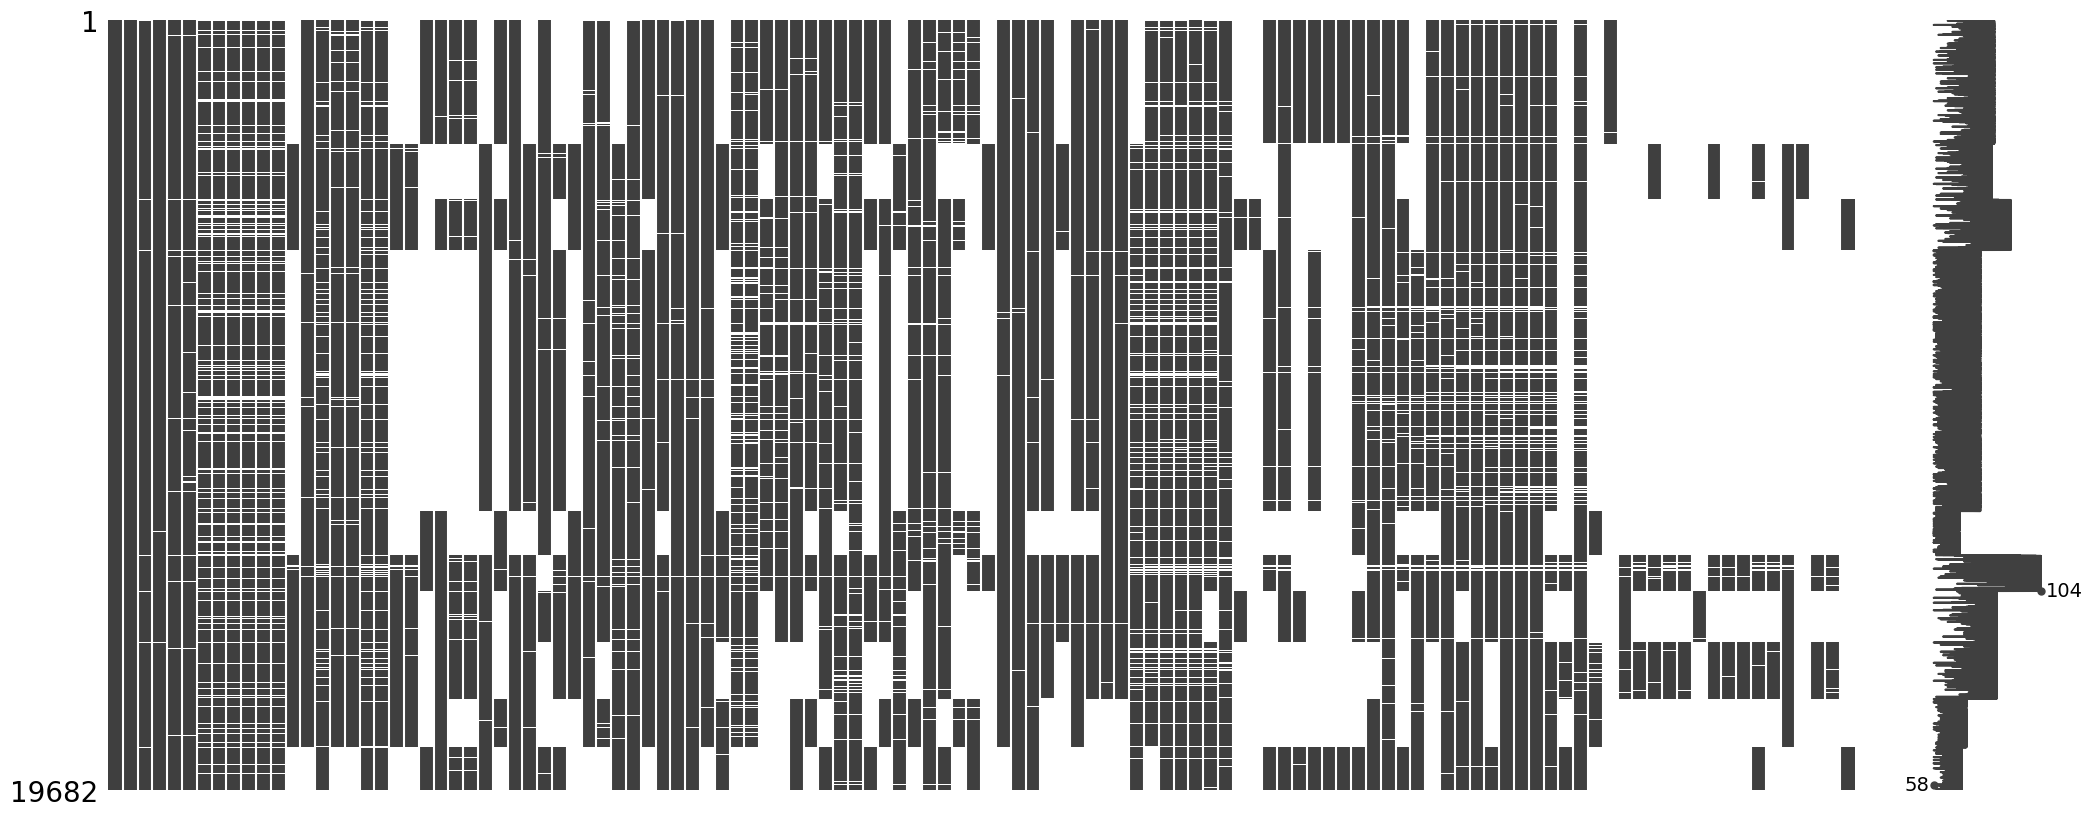

In [85]:
msno.matrix(mental_health_df)

In [86]:
numeric_columns = ['stheight', 'stweight', 'bmi', 'bmipct']
mental_health_df[numeric_columns].describe()

,stheight,stweight,bmi,bmipct
count,17121.000000,17121.000000,17121.000000,1.712100e+04
mean,1.677926,65.487699,23.171922,6.095197e+01
std,0.100418,17.142203,5.325098,2.985224e+01
min,1.300000,29.030000,12.050000,2.970000e-08
25%,1.600000,54.430000,19.630000,3.757000e+01
50%,1.680000,61.240000,21.890000,6.620000e+01
75%,1.750000,72.580000,25.290000,8.818000e+01
max,2.030000,180.990000,62.990000,9.996000e+01


In [87]:
# Get all other columns as categorical (excluding numeric ones)
categorical_columns = [col for col in mental_health_df.columns if col not in numeric_columns]

# Create a summary DataFrame for categorical variables
cat_info = []

for col in categorical_columns:
    cat_info.append([
        col,
        mental_health_df[col].nunique(dropna=False),
        mental_health_df[col].unique(),
        mental_health_df[col].dtype
    ])

df_categorical_info = pd.DataFrame(cat_info, columns=['column_name', 'unique_count', 'unique_values', 'data_type'])

# Show the summary table
print("===== Categorical Variable Summary =====")
print(df_categorical_info)

# Step 3: Print value counts for each categorical variable
print("\n===== Value Counts for Each Categorical Variable =====")
for col in categorical_columns:
    print(f"\n--- {col} ---")
    print(mental_health_df[col].value_counts(dropna=False))

===== Categorical Variable Summary =====
         column_name  unique_count  \
0           sitename            10   
1                age             8   
2                sex             3   
3              grade             5   
4              race4             5   
..               ...           ...   
109     qtransgender             5   
110   qtreatbadlyace             6   
111     qunfairlyace             6   
112  qverbalabuseace             6   
113           qwater             8   

                                         unique_values data_type  
0    [Albuquerque, NM (AB), Chicago, IL (CH), Los A...    object  
1             [nan, 3.0, 4.0, 5.0, 6.0, 7.0, 1.0, 2.0]   float64  
2                                      [nan, 2.0, 1.0]   float64  
3                            [1.0, 2.0, 3.0, 4.0, nan]   float64  
4                            [3.0, nan, 1.0, 4.0, 2.0]   float64  
..                                                 ...       ...  
109                          [nan

In [88]:
gdp_df

,"Table 1. Real Gross Domestic Product, by County, 2020–2023",Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9
0,NaN,Real gross domestic product,NaN,NaN,NaN,NaN,Percent change from preceding period,NaN,NaN,NaN
1,NaN,Thousands of chained (2017) dollars,NaN,NaN,NaN,Rank in state,Percent change,NaN,NaN,Rank in state
2,NaN,2020,2021,2022,2023,2023,2021,2022.0,2023.0,2023
3,United States,"20,267,585,000","21,494,798,000","22,034,828,000","22,671,096,000",--,6.1,2.5,2.9,--
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
3218,Uinta,"781,034","808,678","836,424","870,000",13,3.5,3.4,4.0,17
3219,Washakie,"342,040","346,039","339,019","347,700",19,1.2,-2.0,2.6,20
3220,Weston,"290,300","295,003","289,622","317,107",21,1.6,-1.8,9.5,6
3221,1. Virginia combination areas consist of one o...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [89]:
gdp_df.columns

Index(['Table 1. Real Gross Domestic Product, by County, 2020–2023',
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4', 'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'],
      dtype='object')

In [90]:
gdp_df_edited = gdp_df.drop(columns=[
       'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3',  'Unnamed: 5',
       'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9'])

gdp_df_edited = gdp_df_edited[5:]
gdp_df_edited

,"Table 1. Real Gross Domestic Product, by County, 2020–2023",Unnamed: 4
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [91]:
#rename first column to 'state' second column to 'gdp 2023' in gdp_df_edited

gdp_df_edited = gdp_df_edited.rename(columns={gdp_df_edited.columns[0]:'state', gdp_df_edited.columns[1]:'gdp 2023'})
gdp_df_edited

,state,gdp 2023
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [92]:
mental_health_df['sitename'].unique()

array(['Albuquerque, NM (AB)', 'Chicago, IL (CH)', 'Los Angeles, CA (LO)',
       'New York City, NY (NYC)', 'Oakland, CA (OA)',
       'Philadelphia, PA (PH)', 'Portland, OR (PO)', 'San Diego, CA (SA)',
       'Seattle, WA (SE)', 'Spartanburg County, SC (SP)'], dtype=object)

In [93]:
cities_states = {
    "Albuquerque": "New Mexico",
    "Chicago": "Illinois",
    "Los Angeles": "California",
    "New York City": "New York",
    "Oakland": "California",
    "Philadelphia": "Pennsylvania",
    "Portland": "Oregon",
    "San Diego": "California",
    "Seattle": "Washington",
    "Spartanburg County": "South Carolina"
}

In [94]:
df_mental_health_with_gdp = mental_health_df.copy()

In [95]:
gdp_df_edited

,state,gdp 2023
5,Alabama,"245,354,674"
6,Autauga,"1,945,909"
7,Baldwin,"9,435,720"
8,Barbour,"715,994"
9,Bibb,"466,543"
...,...,...
3218,Uinta,"870,000"
3219,Washakie,"347,700"
3220,Weston,"317,107"
3221,1. Virginia combination areas consist of one o...,NaN


In [96]:
df_mental_health_with_gdp['state'] = df_mental_health_with_gdp['sitename'].apply(lambda x: cities_states[x.split(', ')[0]] if x.split(', ')[0] in cities_states else None)

In [60]:
df_mental_health_with_gdp['gdp 2023'] = df_mental_health_with_gdp['state'].apply(lambda x: gdp_df_edited[gdp_df_edited['state'] == x]['gdp 2023'].values[0] if x is not None else None)

In [61]:
df_mental_health_with_gdp.to_csv('OutputData/mental_health_with_gdp.csv', index=False)

In [62]:
df_mental_health_with_gdp['gdp 2023']

,gdp 2023
0,"110,323,705"
1,"110,323,705"
2,"110,323,705"
3,"110,323,705"
4,"110,323,705"
...,...
22123,"262,298,502"
22124,"262,298,502"
22125,"262,298,502"
22126,"262,298,502"


In [63]:
df = pd.read_csv('OutputData/mental_health_with_gdp.csv')

In [64]:
df.head()

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qsexabuseace,qtalkadultace,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater,state,gdp 2023
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705"


In [65]:
col_info=[]

for col in df.columns:
  col_info.append([col,df[col].nunique(),df[col].unique(),df[col].dtype])

df_cols = pd.DataFrame(col_info, columns=['column_name','unique_num','unique_values','data_type'])
df_cols.head()

,column_name,unique_num,unique_values,data_type
0,sitename,10,"[Albuquerque, NM (AB), Chicago, IL (CH), Los A...",object
1,age,7,"[nan, 3.0, 4.0, 5.0, 6.0, 7.0, 1.0, 2.0]",float64
2,sex,2,"[nan, 2.0, 1.0]",float64
3,grade,4,"[1.0, 2.0, 3.0, 4.0, nan]",float64
4,race4,4,"[3.0, nan, 1.0, 4.0, 2.0]",float64


In [66]:
df_cols.sort_values(by='unique_num', ascending=False)

,column_name,unique_num,unique_values,data_type
9,bmipct,4506,"[nan, 76.67, 55.7, 75.24, 15.48, 72.96, 53.23,...",float64
8,bmi,1662,"[nan, 20.99, 19.15, 20.82, 16.67, 20.58, 18.99...",float64
7,stweight,266,"[nan, 57.15, 52.16, 56.7, 49.9, 66.68, 54.89, ...",float64
6,stheight,30,"[nan, 1.65, 1.73, 1.8, 1.7, 1.6, 1.9, 1.63, 1....",float64
0,sitename,10,"[Albuquerque, NM (AB), Chicago, IL (CH), Los A...",object
...,...,...,...,...
69,q56,2,"[nan, 1.0, 2.0]",float64
103,qincarparentace,2,"[nan, 2.0, 1.0]",float64
110,qsexabuseace,2,"[nan, 2.0, 1.0]",float64
105,qlivedwabuseace,2,"[nan, 2.0, 1.0]",float64


In [67]:
df_states= pd.read_csv('Data/joined_state_data.csv')

In [68]:
df_states

,state,Unemployment Rate(Percent),Mean household income (dollars)
0,Washington,4.5%,"129,161"
1,South Carolina,4.3%,"92,578"
2,Pennsylvania,4.2%,"102,578"
3,Oregon,4.1%,"107,214"
4,New York,5.0%,"122,227"
5,New Mexico,4.8%,"85,782"
6,Illinois,4.7%,"110,930"
7,California,5.5%,"134,491"


In [69]:
df = df.merge(df_states, how='left', on='state')
df.to_csv('OutputData/mental_health_with_socioeconomic_indicators.csv', index=False)
df


,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,qtalkfriendace,qtransgender,qtreatbadlyace,qunfairlyace,qverbalabuseace,qwater,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19677,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.60,54.43,21.26,48.05,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"
19678,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.50,47.17,20.96,44.14,...,NaN,NaN,NaN,NaN,NaN,4.0,South Carolina,"262,298,502",4.3%,"92,578"
19679,"Spartanburg County, SC (SP)",7.0,1.0,4.0,3.0,4.0,1.50,47.63,21.16,46.85,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"
19680,"Spartanburg County, SC (SP)",7.0,1.0,4.0,1.0,6.0,1.65,52.16,19.15,19.47,...,NaN,NaN,NaN,NaN,NaN,7.0,South Carolina,"262,298,502",4.3%,"92,578"


## Handling Missing Data

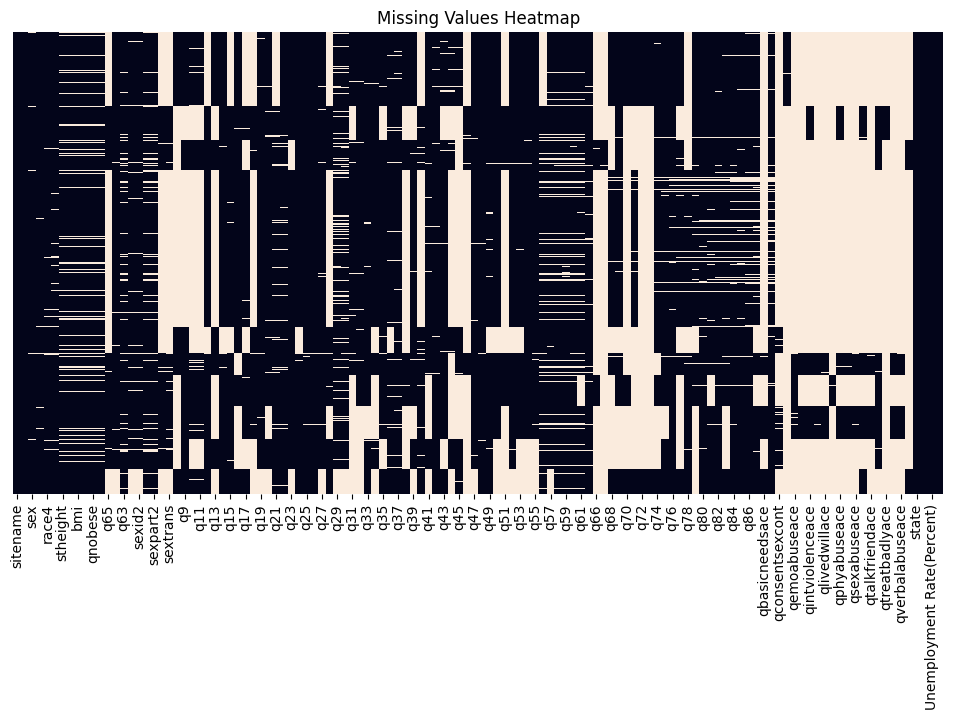

In [70]:
df = pd.read_csv('OutputData/mental_health_with_socioeconomic_indicators.csv')
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False)
plt.title("Missing Values Heatmap")
plt.show()

In [71]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q67                    18409
qparentalmonitoring    18388
qtreatbadlyace         18268
qlivedwillace          17468
qincarparentace        17466
                       ...  
q26                      135
grade                    126
sex                      121
q25                      114
age                       30
Length: 117, dtype: int64


In [72]:
# Set threshold for high missingness (70%)
threshold = 0.70

# Calculate fraction of missing values per column
missing_fraction = df.isnull().mean()

# Identify columns exceeding the threshold
high_missing_cols = missing_fraction[missing_fraction > threshold].index.tolist()

# Print summary
print(f"Columns with >{int(threshold * 100)}% missing values:")
print(high_missing_cols)

# Drop them from the DataFrame
df.drop(columns=high_missing_cols, inplace=True)

print(f"\nDropped {len(high_missing_cols)} columns due to high missingness.")
print(f"Remaining columns: {df.shape[1]}")



Columns with >70% missing values:
['q46', 'q51', 'q66', 'q67', 'q70', 'q72', 'q73', 'qbasicneedsace', 'qconsentsexcont', 'qcurrentopioid', 'qemoabuseace', 'qincarparentace', 'qintviolenceace', 'qlivedwabuseace', 'qlivedwillace', 'qparentalmonitoring', 'qphyabuseace', 'qphyviolenceace', 'qsexabuseace', 'qtalkadultace', 'qtalkfriendace', 'qtreatbadlyace', 'qunfairlyace', 'qverbalabuseace', 'qwater']

Dropped 25 columns due to high missingness.
Remaining columns: 97


In [73]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q44         13435
q8          13391
q45         12573
sextrans    12354
transg      12236
            ...  
q26           135
grade         126
sex           121
q25           114
age            30
Length: 92, dtype: int64


In [74]:
df = df.dropna(subset=['q26'])
df = df.dropna(subset=['q27'])
df = df.dropna(subset=['q84'])
df = df.reset_index(drop=True)

In [75]:
# For each numeric column, calculate the mean and use it to fill missing values.
for col in numeric_columns:
    mean_value = df[col].mean()
    df[col] = df[col].fillna(mean_value)
    print(f"Filled missing values in '{col}' with mean: {mean_value:.2f}")

Filled missing values in 'stheight' with mean: 1.68
Filled missing values in 'stweight' with mean: 65.21
Filled missing values in 'bmi' with mean: 23.09
Filled missing values in 'bmipct' with mean: 60.41


In [76]:
missing_summary = df.isnull().sum()
missing_summary = missing_summary[missing_summary > 0].sort_values(ascending=False)
print(missing_summary)

q8       12057
q45      11189
q44      10923
q38      10668
q28       9999
         ...  
q82        125
grade      107
sex        106
q25         84
age         26
Length: 85, dtype: int64


In [77]:
df

,sitename,age,sex,grade,race4,race7,stheight,stweight,bmi,bmipct,...,q84,q85,q86,q87,qclose2people,qtransgender,state,gdp 2023,Unemployment Rate(Percent),Mean household income (dollars)
0,"Albuquerque, NM (AB)",NaN,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,3.0,4.0,1.0,7.0,3.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
1,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,4.0,1.0,1.0,3.0,2.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
2,"Albuquerque, NM (AB)",3.0,NaN,1.0,NaN,NaN,1.677391,65.20692,23.086023,60.410003,...,1.0,6.0,1.0,1.0,1.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
3,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,3.0,4.0,1.0,2.0,2.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
4,"Albuquerque, NM (AB)",3.0,NaN,1.0,3.0,4.0,1.677391,65.20692,23.086023,60.410003,...,4.0,4.0,1.0,2.0,3.0,NaN,New Mexico,"110,323,705",4.8%,"85,782"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16934,"Seattle, WA (SE)",7.0,1.0,4.0,3.0,4.0,1.630000,56.70000,21.340000,49.070000,...,5.0,2.0,1.0,2.0,5.0,1.0,Washington,"985,765",4.5%,"129,161"
16935,"Seattle, WA (SE)",7.0,1.0,4.0,2.0,3.0,1.730000,54.43000,18.180000,8.890000,...,2.0,2.0,1.0,1.0,4.0,1.0,Washington,"985,765",4.5%,"129,161"
16936,"Seattle, WA (SE)",7.0,1.0,4.0,NaN,NaN,1.730000,64.41000,21.520000,51.340000,...,4.0,4.0,1.0,1.0,1.0,1.0,Washington,"985,765",4.5%,"129,161"
16937,"Seattle, WA (SE)",7.0,1.0,4.0,1.0,6.0,1.570000,52.16000,21.160000,46.750000,...,5.0,4.0,1.0,1.0,2.0,3.0,Washington,"985,765",4.5%,"129,161"


In [78]:
df.to_csv('OutputData/mental_health_full.csv', index=False)